In [12]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A

In [13]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [14]:

pth='/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png'
im=np.array(Image.open(pth))
t1 = A.Compose([
    A.Resize(160,240),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
imm=t1(image=im,mask=im)
m=imm['mask']
print(m.shape,im.shape)
i=torch.max(m,dim=2)[0]
print(i.shape)
#plt.imshow(i)


torch.Size([160, 240, 3]) (600, 800, 3)
torch.Size([160, 240])


In [15]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None,val=False):
        self.root_dir = root_dir
        self.transform = transform
        self.val=val

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if self.val:
            idx+=1000
        video_path = os.path.join(self.root_dir, 'video_{}'.format(idx))
        image_path=os.path.join(video_path,'image_21.png')
        img=np.array(Image.open(image_path))
        mask_path = os.path.join(video_path, 'mask.npy')
        masks = np.load(mask_path)
        mask=masks[21]
        if self.transform is not None:
            aug = self.transform(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            #print(mask.shape)
            #mask = torch.max(mask,dim=2)[0]
        return img, mask

In [16]:
train_dir='/kaggle/input/dataset-segmenatation/Dataset_segmentation/train'
val_dir='/kaggle/input/dataset-segmenatation/Dataset_segmentation/val'
raw_dir="/kaggle/input/dataset-segmenatation/Dataset_segmentation"

In [17]:
t1 = A.Compose([
    A.Resize(160,240),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [35]:
from torch.utils.data import Dataset,DataLoader, random_split

train_dataset = VideoDataset(root_dir=os.path.join(raw_dir,'train') ,transform=t1)
val_dataset= VideoDataset(root_dir=os.path.join(raw_dir,'val'),transform=t1,val=True)
tot_dataset=torch.utils.data.ConcatDataset([train_dataset,val_dataset])
dataset_size = len(tot_dataset)
print(f"Dataset Size={dataset_size}")
train_size = int(dataset_size * 0.70)
val_size = int((dataset_size - train_size) * 0.15)
test_size = dataset_size - train_size - val_size
#train_loader=DataLoader(train_dataset,batch_size=8,shuffle=True)
#val_loader=DataLoader(val_dataset,batch_size=8,shuffle=True)
train_set, val_set, test_set = random_split(tot_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True,num_workers=2)
val_loader=DataLoader(val_set,batch_size=8,shuffle=True,num_workers=2)
test_loader=DataLoader(test_set,batch_size=8,shuffle=True,num_workers=2)
print(len(train_loader))

Dataset Size=2000
175


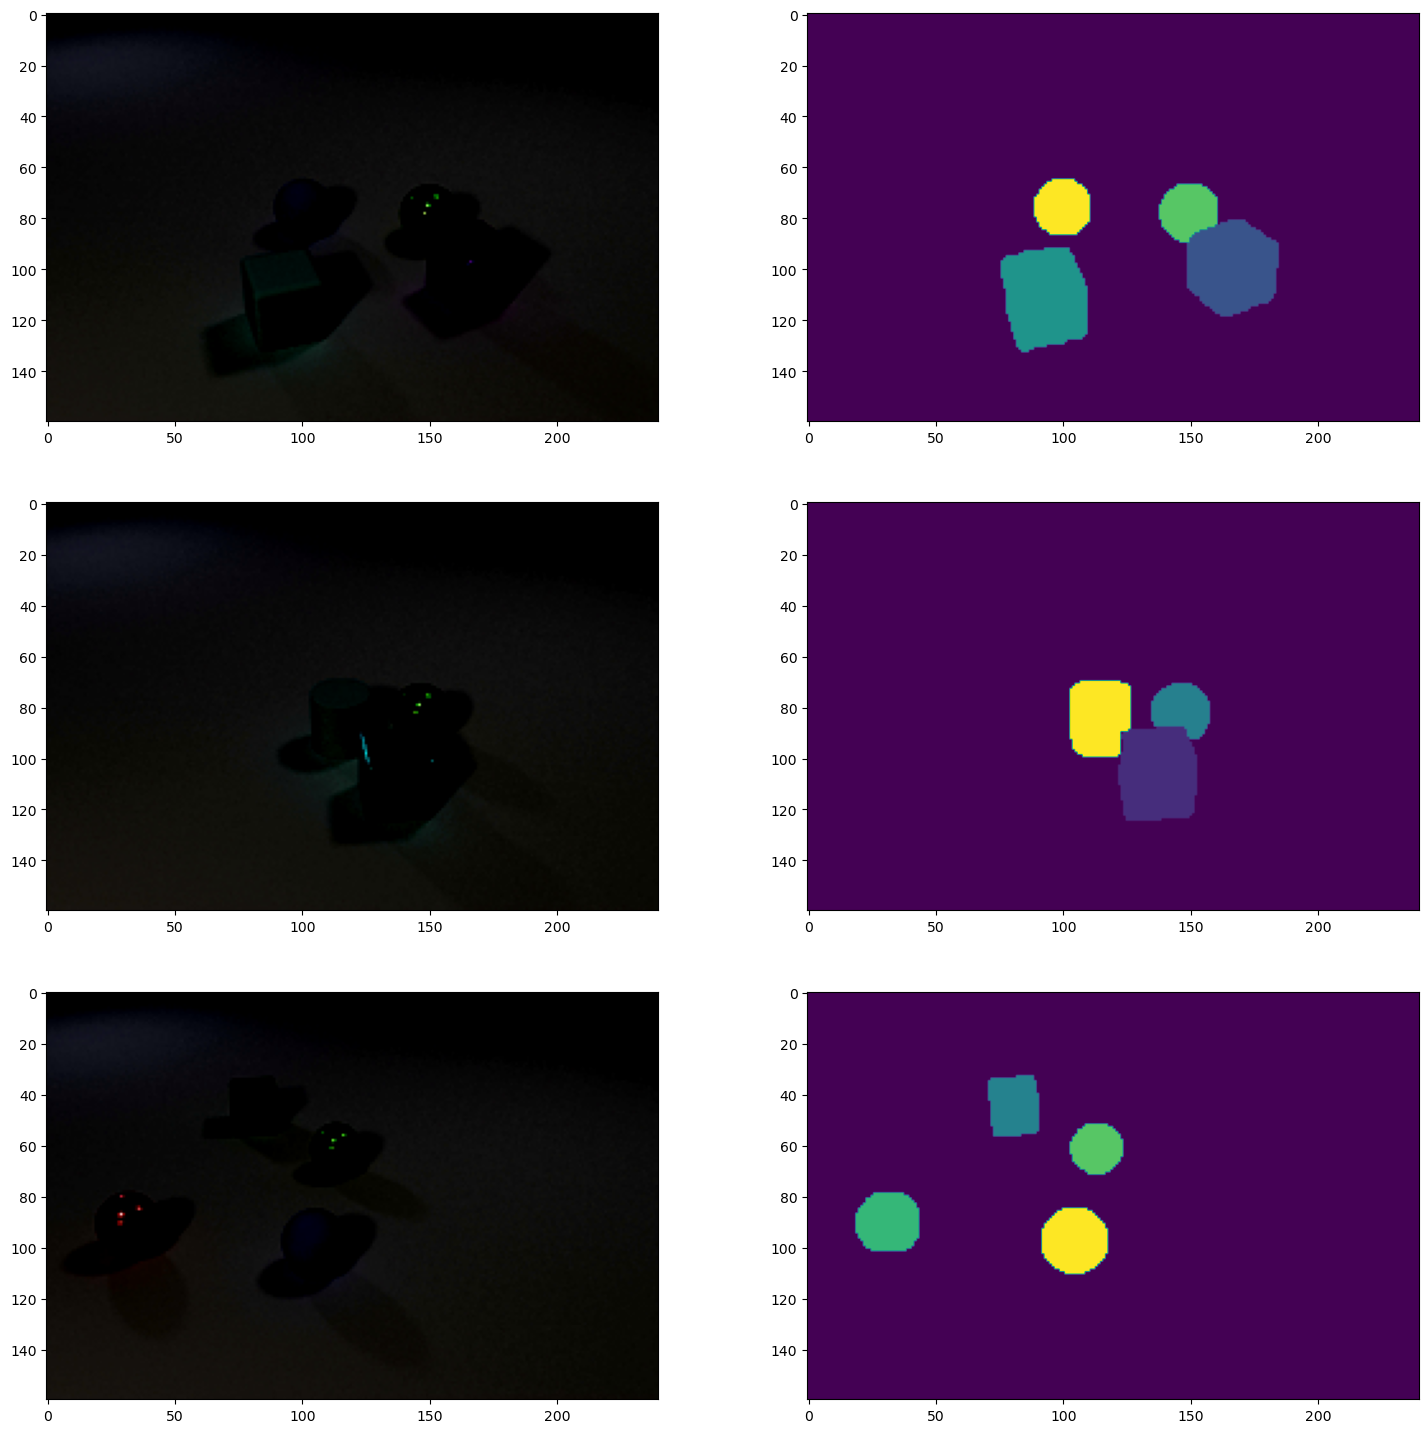

In [36]:
for img,mask in train_loader:
    #print(img.shape)
    #img1=img[0,:,:,:].permute(1,2,0)
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

In [20]:
!pip install torchsummary 

In [37]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)

In [38]:
class unet_model(nn.Module):
    def __init__(self,out_channels=49,features=[64, 128, 256, 512]):
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [39]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [40]:
model = unet_model().to(DEVICE)

In [41]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
    encoding_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [42]:
LEARNING_RATE = 1e-4
num_epochs = 25

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [44]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader),total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

100%|██████████| 175/175 [00:31<00:00,  5.50it/s, loss=0.0118] 


In [58]:
import torchmetrics
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [46]:
check_accuracy(train_loader, model)

Got 53671372/53760000 with acc 99.84
Dice score: 32.27574920654297


In [47]:
check_accuracy(val_loader, model)

Got 3446179/3456000 with acc 99.72
Dice score: 32.14238357543945


In [59]:
check_accuracy(test_loader, model)

Got 19523464/19584000 with acc 99.69
Dice score: 31.95292854309082


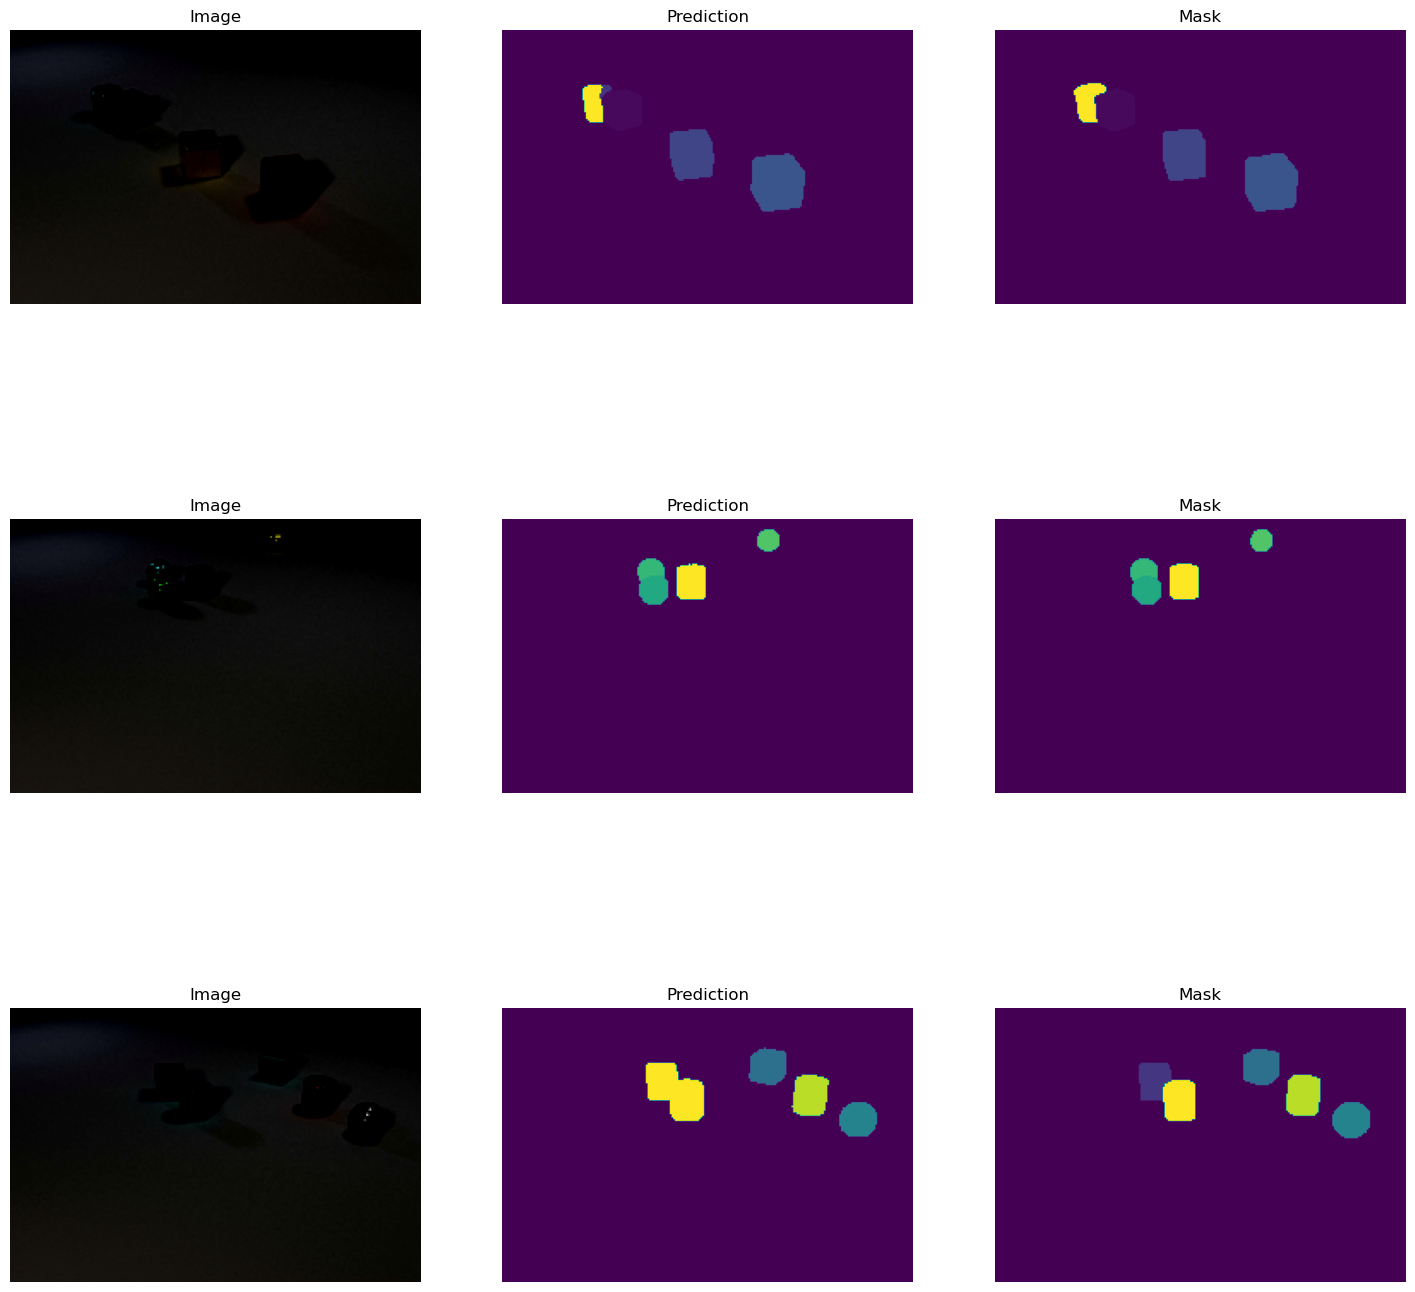

In [49]:
for x,y in test_loader:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break

In [51]:
torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
      }, 'unet_model.pth')

In [88]:
ans=[]
mask=[]
for x,y in test_loader:
    x=x.to(DEVICE)
    y=y.to(DEVICE)
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    #print(y.shape)
    bs,h,w=y.shape
    for i in range(bs):
        ans.append(preds[i,:,:])
        mask.append(y[i,:,:])
for x,y in val_loader:
    x=x.to(DEVICE)
    y=y.to(DEVICE)
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    bs,h,w=y.shape
    for i in range(bs):
        ans.append(preds[i,:,:])
        mask.append(y[i,:,:])


In [89]:
len(ans)

600

In [90]:
ans[0].shape

torch.Size([160, 240])

In [94]:
#a=ans[0:63]
stacked_ans=torch.stack(ans,dim=0).to(DEVICE)
print(stacked_ans.shape)
stacked_mask=torch.stack(mask,dim=0).to(DEVICE)
print(stacked_mask.shape)

torch.Size([600, 160, 240])
torch.Size([600, 160, 240])


In [95]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49).to(DEVICE)
            
print(jaccard(stacked_ans, stacked_mask))


tensor(0.9192, device='cuda:0')
